# TopoCluster Regression: IQR Comparison (for energy *scaling* networks)

This notebook makes plots of energy resolution (defined by the interquartile range for distributions of the ratio of predicted energy to calibration hits), specifically for regression networks that predict a *corrective factor* with which to multiply the reco energy (to get a predicted energy). This is in contrast with our "typical" regression networks that directly try to predict the energy itself.

In [1]:
# source & subdir -- used to specify a set of networks that were trained with particular data & settings
source = 'pion'
subdir = 'pion4'

#### 1) Initial setup

In [2]:
# Import some basic libraries.
import sys, os, glob, pathlib
import numpy as np
import h5py as h5
import matplotlib.pyplot as plt
import ROOT as rt # used for plotting
    
# Import our resolution utilities
path_prefix = os.getcwd() + '/../'
if(path_prefix not in sys.path): sys.path.append(path_prefix)
from util import plot_util       as pu
from util import ml_util         as mu
from util import qol_util        as qu

# regression-specific imports
from util.regression import plot_util as rpu

rt.gStyle.SetOptStat(0)
# use our custom dark style for plots
plotstyle = qu.PlotStyle('dark')
plotstyle.SetStyle() # still need to manually adjust legends, paves

plotpath = os.getcwd() + '/Plots/{}/'.format(subdir)
modelpath = os.getcwd() + '/Models/{}/'.format(subdir)
paths = [plotpath, modelpath]
for path in paths:
    try: os.makedirs(plotpath)
    except: pass

# metadata
layers = ["EMB1", "EMB2", "EMB3", "TileBar0", "TileBar1", "TileBar2"]
cell_size_phi = [0.098, 0.0245, 0.0245, 0.1, 0.1, 0.1]
cell_size_eta = [0.0031, 0.025, 0.05, 0.1, 0.1, 0.2]
len_phi = [4, 16, 16, 4, 4, 4]
len_eta = [128, 16, 8, 4, 4, 2]
cell_shapes = {layers[i]:(len_eta[i],len_phi[i]) for i in range(len(layers))}

Welcome to JupyROOT 6.24/02


2021-07-29 07:34:45.267169: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


#### 2) Get Results

Rather than get the data, networks & re-evaluate everything, we're just going to load network outputs from HDF5 files that were saved during training & evaluation in our training notebook. This means that this notebook should run rather quickly (and not require GPU resources for quick network evaluation). Just make sure not to throw out the HDF5 files with results, otherwise you will have to remake them with the other notebook.

In [3]:
# list of networks to evaluate
models = ['all','simple','simple_cnn','split_emb_cnn']
colors = [rt.kRed, rt.kYellow, plotstyle.main, rt.kGreen, plotstyle.text]

# drop any models we don't find
models2 = []
for model in models:
    add = True
    files_to_find = [modelpath + '{a}/{a}_charged_output.h5'.format(a=model),
                     modelpath + '{a}/{a}_neutral_output.h5'.format(a=model)
                    ]
    for file in files_to_find:
        if(not pathlib.Path(file).exists()):
            add = False
    if(add): models2.append(model)
models = models2
            

# # autokeras version
# models = ['auto']
# colors = [plotstyle.main]

result_files = {
    model:{
        'pp':h5.File(modelpath + '{a}/{a}_charged_output.h5'.format(a=model),'r'),
        'p0':h5.File(modelpath + '{a}/{a}_neutral_output.h5'.format(a=model),'r'),
    }
    for model in models
}

# #autokeras version
# result_files = {
#     model:{
#         'pp':h5.File(modelpath + '{}/model_pp_output.h5'.format(model,model),'r'),
#         'p0':h5.File(modelpath + '{}/model_p0_output.h5'.format(model,model),'r'),
#     }
#     for model in models
# }


results = {
    model:{
        key:{
            name:file[name][file['test'][:]]
            for name in ['output','truth','reco']
        }
        for key,file in result_files[model].items()
    }
    for model in models
}

for fdict in result_files.values():
    for key,val in fdict.items():
        val.close()

#### 3) Make IQR plots (with ROOT)

**TODO**: Try using some of our custom (matplotlib-based) functions. Maybe the plots will look nice?

In [4]:
nbins = 80
x_range = (0.,80.)

iqr_hists = {
    model:{
        key: rpu.IqrPlot(data['output'] * data['reco'],data['truth'], nbins = nbins, x_range=x_range, normalize=True)
        for key,data in results[model].items()
    }
    for model in models
}

# add in the reco info
iqr_hists['reco'] = {
    key: rpu.IqrPlot(data['reco'],data['truth'], nbins = nbins, x_range=x_range)
    for key,data in results[models[0]].items()
}

plot_keys = models
plot_keys = ['reco'] + models # make sure reco is plotted first with orange

if(plotstyle.curve not in colors): colors = [plotstyle.curve] + colors

Info in <TCanvas::Print>: png file /local/home/jano/ml4pions/LCStudies/regression2/Plots/pion4/iqr_pp.png has been created
Info in <TCanvas::Print>: png file /local/home/jano/ml4pions/LCStudies/regression2/Plots/pion4/iqr_p0.png has been created


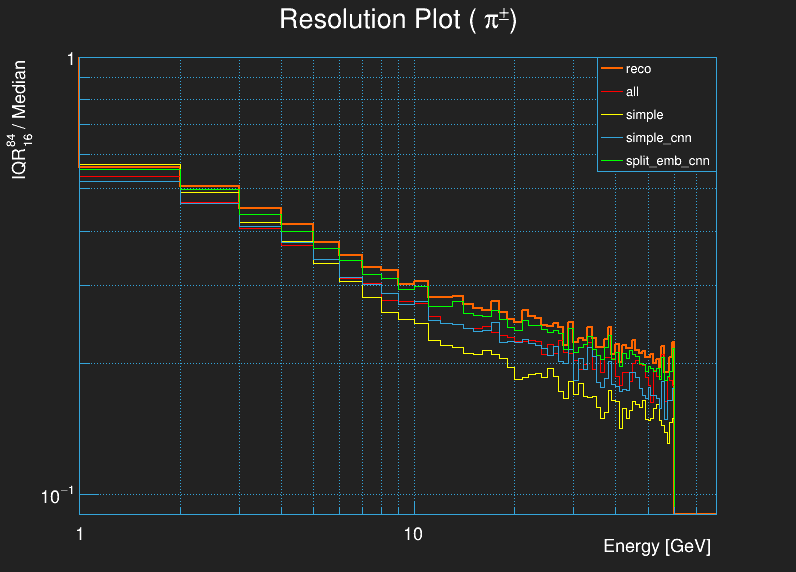

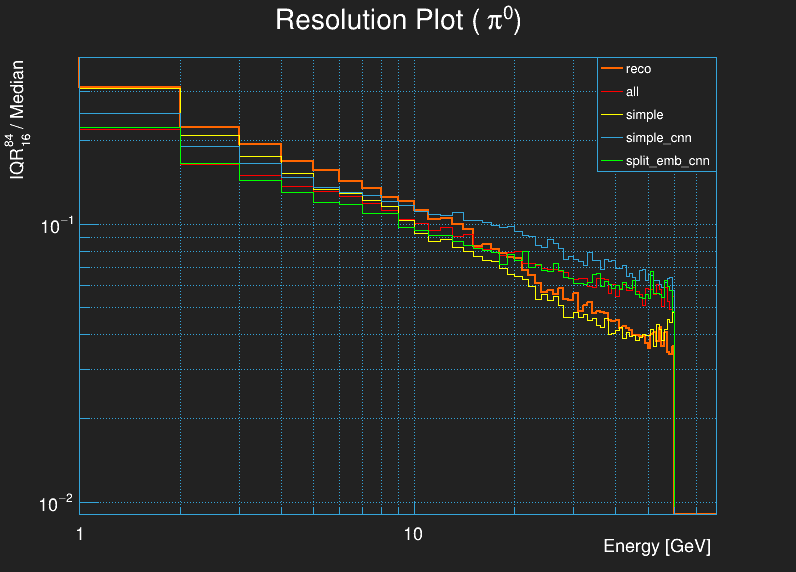

In [5]:
canvases = []
stacks = []
legends = []

pname = {
    'pp':'#pi^{#pm}',
    'p0':'#pi^{0}'
}

ranges = {
    'pp':(9.0e-2,1.0),
    'p0':(9.0e-3,4.0e-1)
}

pi_latex = {
    'p0': '$\pi^0$',
    'pp': '$\pi^\pm$',
}

for pkey in pname.keys():

    c = rt.TCanvas(qu.RN(),'c1',800,600)
    stack = rt.THStack()
    leg = rt.TLegend(0.75,0.7,0.9,0.9)
    leg.SetTextColor(plotstyle.text)

    for i,model in enumerate(plot_keys):
        iqr_hists[model][pkey].SetLineColor(colors[i])
        if(model == 'reco'): iqr_hists[model][pkey].SetLineWidth(2)
        stack.Add(iqr_hists[model][pkey])
        leg.AddEntry(iqr_hists[model][pkey],model,'l')

    stack.Draw('NOSTACK HIST') # use 'NOSTACK HIST' for more accurate (but harder-to-read) version, the curves are hiding binning
    
    stack.SetMinimum(ranges[pkey][0])
    stack.SetMaximum(ranges[pkey][1])
    rt.gPad.SetLogx()
    rt.gPad.SetLogy()
    rt.gPad.SetGrid()

    stack.SetTitle('Resolution Plot ({});Energy [GeV];{} / Median'.format(pname[pkey], 'IQR_{16}^{84}'))
    leg.Draw()
    c.Draw()
    
    c.SaveAs(plotpath + 'iqr_{}.png'.format(pkey))
    
    stacks.append(stack)
    canvases.append(c)
    legends.append(leg)

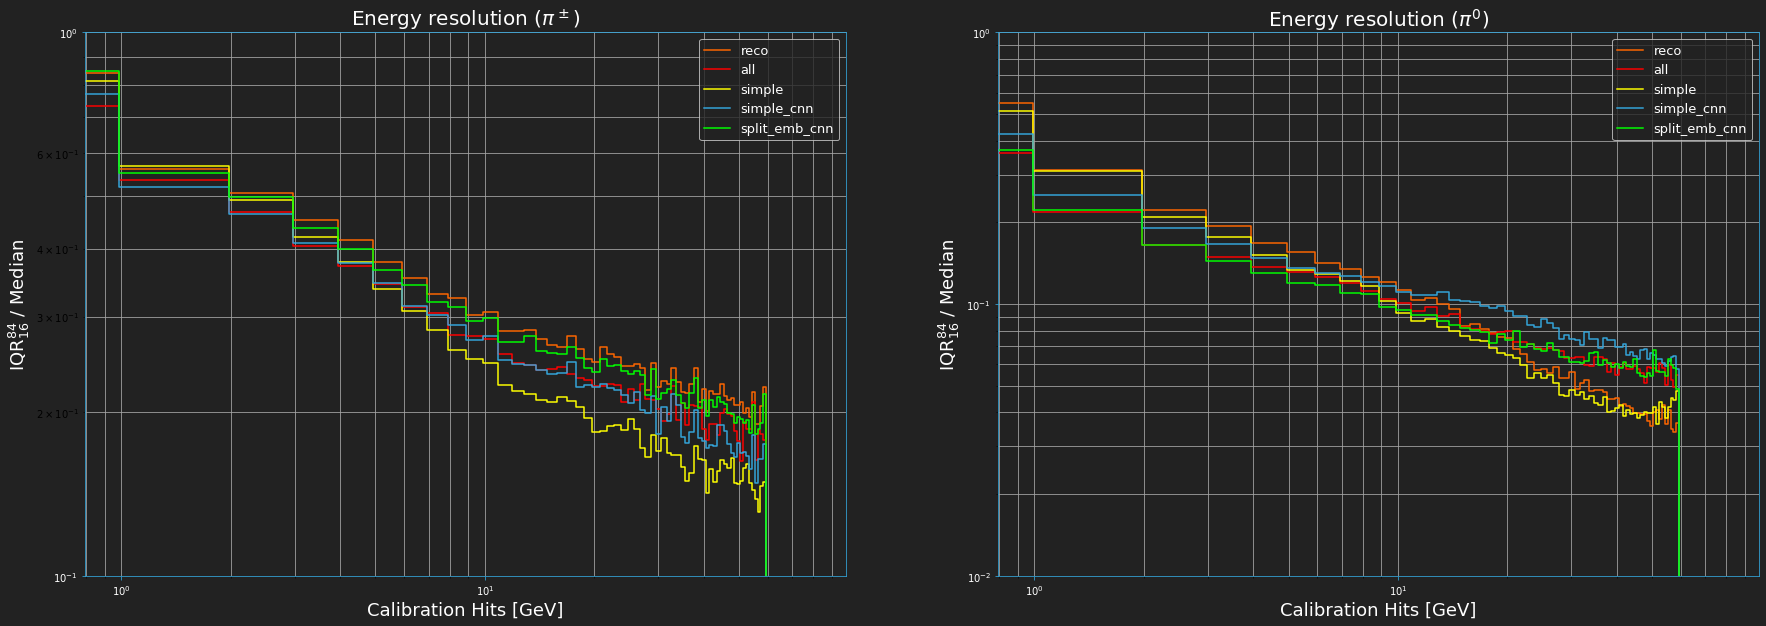

In [6]:
def TColor2RGB(color_index):
    color = rt.gROOT.GetColor(color_index)
    return (color.GetRed(), color.GetGreen(), color.GetBlue())

colors_plt = [TColor2RGB(c) for c in colors]

# Some clunky code to make sure we use the correct bin settings from before (in case we change things in notebook).
nbins = list(list(iqr_hists.values())[0].values())[0].GetNbinsX() # will be the same for all
x_min = list(list(iqr_hists.values())[0].values())[0].GetBinLowEdge(1)
bin_width = list(list(iqr_hists.values())[0].values())[0].GetBinLowEdge(2) - x_min
x_max = list(list(iqr_hists.values())[0].values())[0].GetBinLowEdge(nbins) + bin_width
x_range = (x_min, x_max)
bin_edges = np.linspace(*x_range, nbins + 1, endpoint=False)

fig, axs = plt.subplots(1,2,figsize=(30,10))
for i,key in enumerate(['pp','p0']):
    ax = axs[i]
    plotstyle.SetStylePlt(ax)
    
    for j,model in enumerate(plot_keys):
        rhist = iqr_hists[model][key]

        # get all the y-values from the histogram -- includes the empty bins
        y_vals = np.array([rhist.GetBinContent(l+1) for l in range(nbins)])

        x_vals = bin_edges
        x_vals = np.vstack((x_vals,x_vals)).reshape((-1,),order='F')[1:-1]           
        y_vals = np.vstack((y_vals,y_vals)).reshape((-1,),order='F')
        
        label = model
        ax.plot(x_vals,y_vals, color=colors_plt[j],label=label)
         
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    y_lim = (1.0e-1,1.0)
    if(key == 'p0'): y_lim = (1.0e-2,1.0)
    ax.set_ylim(y_lim)
    
    legend = ax.legend(facecolor=plotstyle.canv_plt,loc='upper right')
    for leg_text in legend.get_texts(): leg_text.set_color(plotstyle.text_plt)
    
    ax.set_title('Energy resolution ({})'.format(pi_latex[key]), fontsize=20)
    ax.set_xlabel('Calibration Hits [GeV]')
    ax.set_ylabel('IQR$^{84}_{16}$ / Median')
    ax.grid(True,which='both',color=plotstyle.grid_plt)
    
fig.patch.set_facecolor(plotstyle.canv_plt)
plt.savefig(plotpath + 'resolution.png',dpi=300)

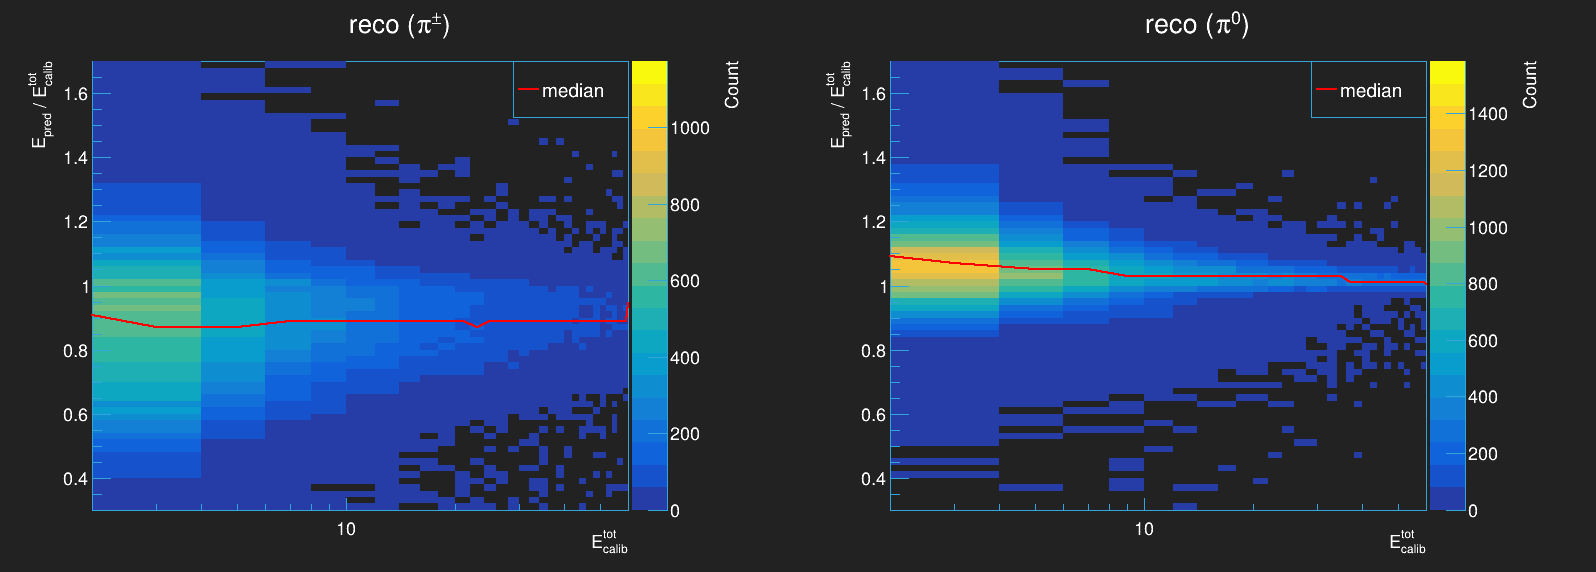

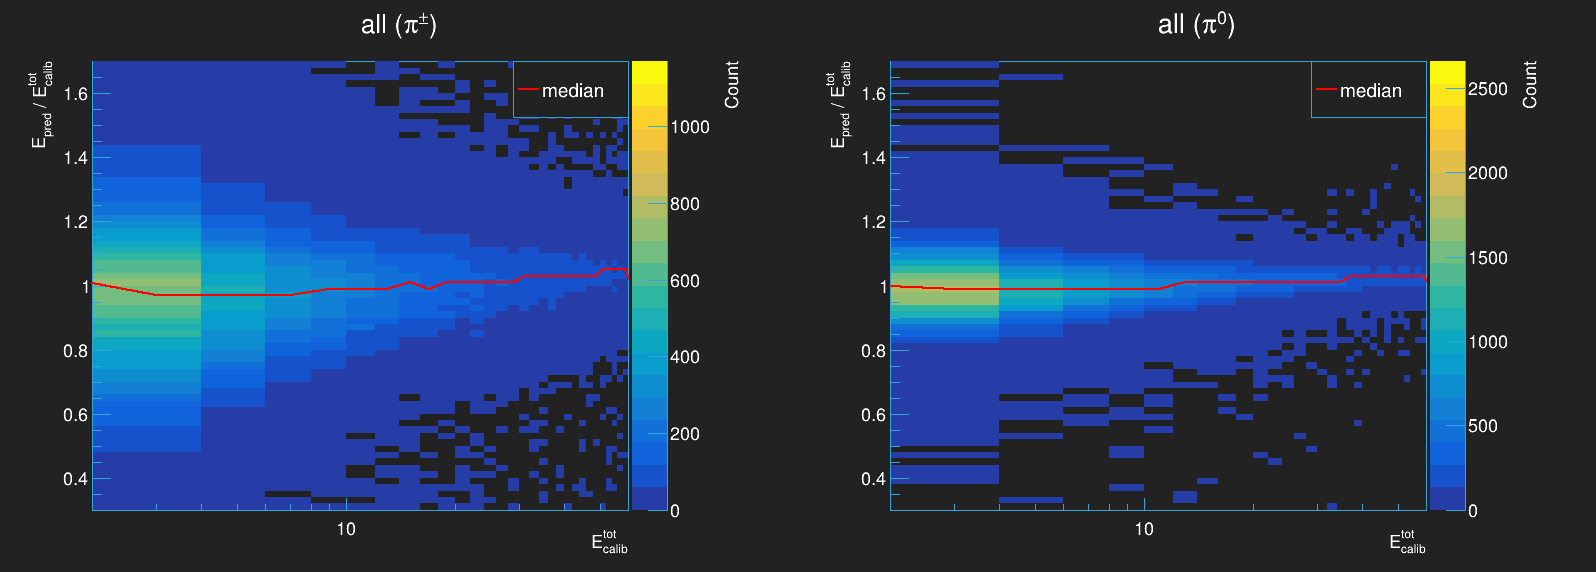

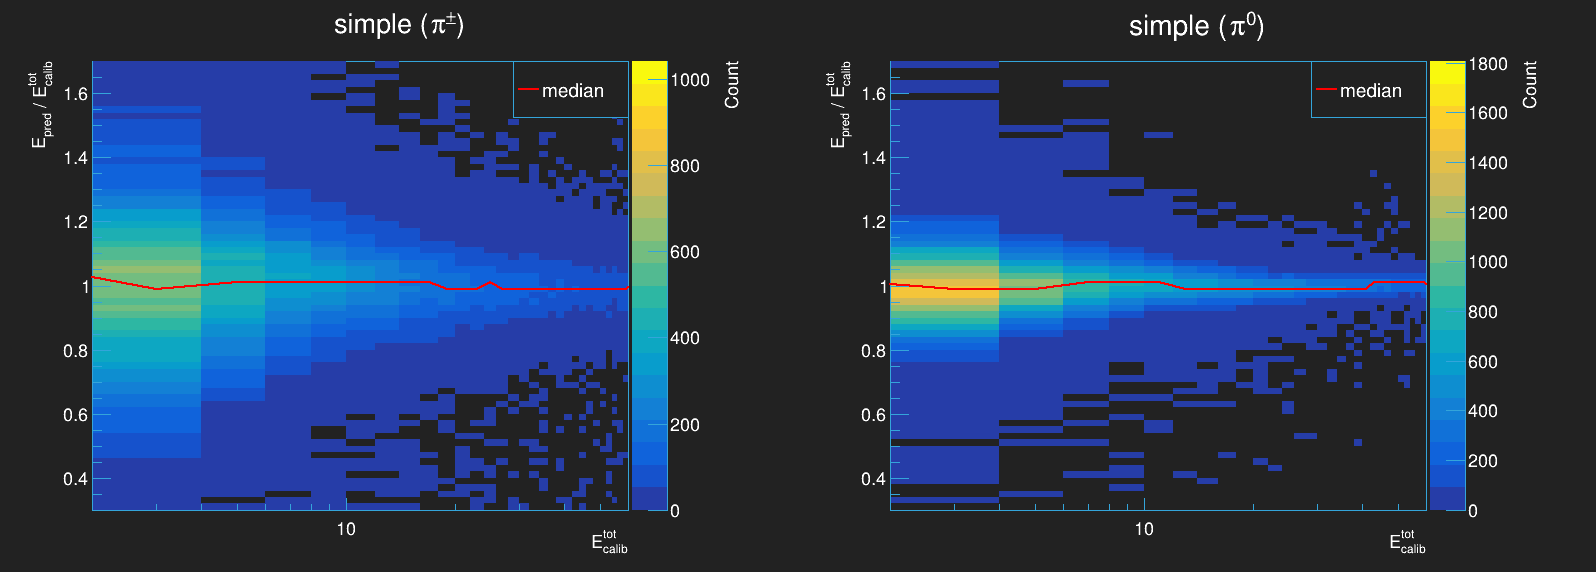

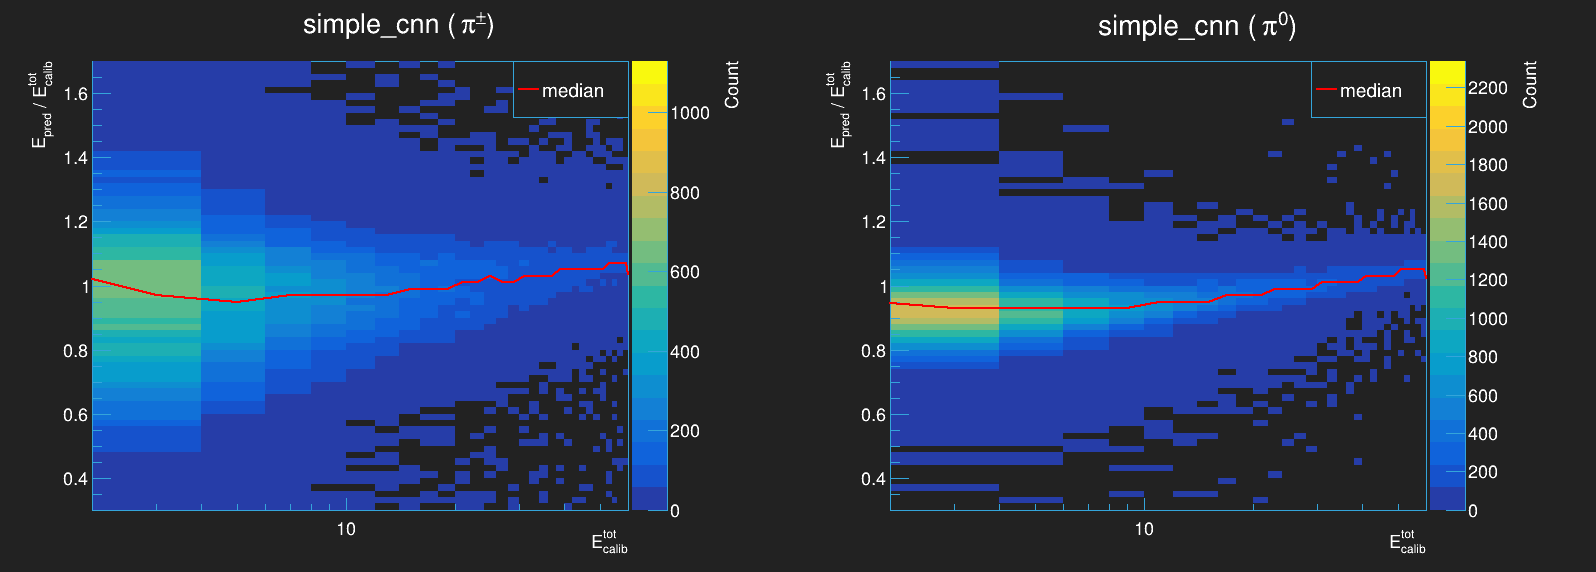

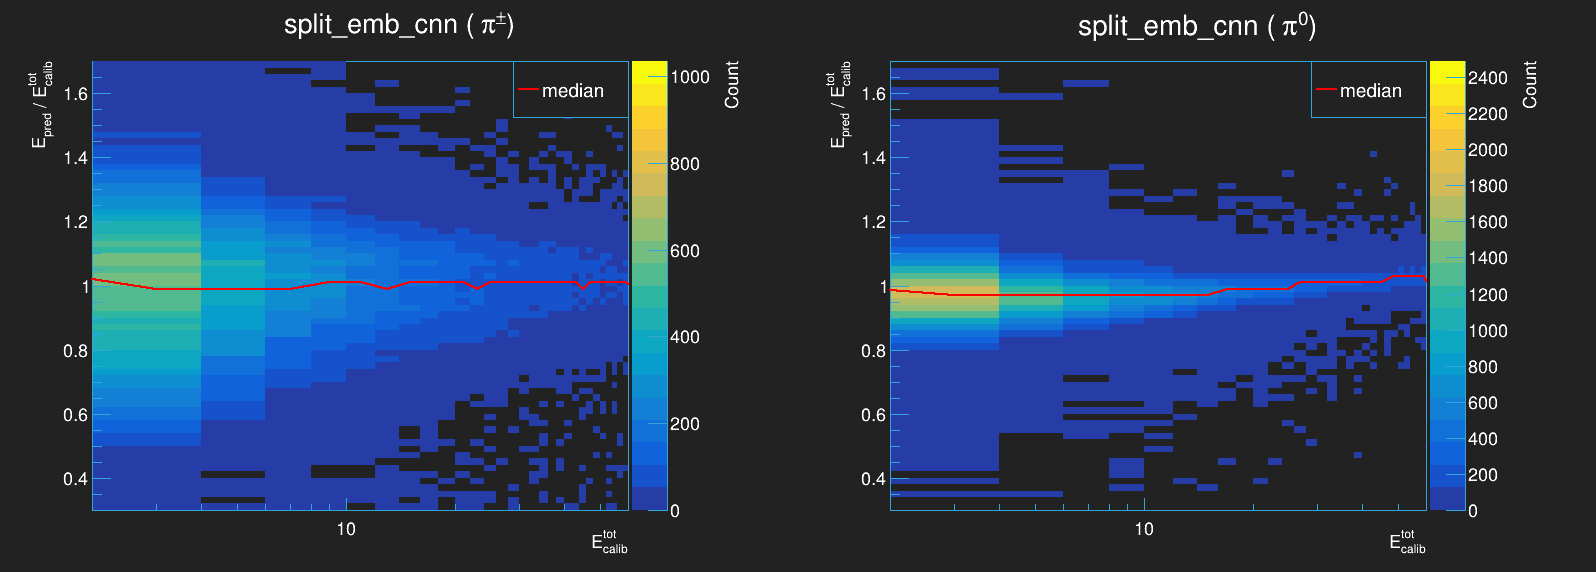

In [7]:
hists = []
curves = []

nbins = [1000,70]
title_suffix = ';E_{calib}^{tot};E_{pred} / E_{calib}^{tot};Count'

#models_short = ['reco', 'all', 'simple','simple_cnn','split_emb_cnn']

# #autokeras version
# models_short = ['reco'] + models 

for model in plot_keys:
    
    c = rt.TCanvas(qu.RN(),model,1600,600)
    c.Divide(2,1)
    
    for i,pkey in enumerate(pname.keys()):
        
        c.cd(i+1)
        
        if(model == 'reco'): curve, h = rpu.EnergyPlot2D(results[models[0]][pkey]['reco'], results[models[0]][pkey]['truth'],
                                                         title='{} ({})'.format(model, pname[pkey]) + title_suffix,
                                                         nbins = nbins
                                                        )
        
        else: curve, h = rpu.EnergyPlot2D(results[model][pkey]['output'] * results[model][pkey]['reco'], results[model][pkey]['truth'],
                                          title='{} ({})'.format(model, pname[pkey]) + title_suffix,
                                          nbins = nbins
                                         )
        
        leg = rt.TLegend(0.65,0.8,0.8,0.9)
        leg.SetTextColor(plotstyle.text)
        leg.AddEntry(curve,'median','l')
        

        h.Draw('COLZ')
        h.GetXaxis().SetRangeUser(.1,6.0e1)
        h.GetZaxis().SetTitleOffset(1.5)
        curve.Draw('SAME')
        leg.Draw()
        rt.gPad.SetLogx()
        rt.gPad.SetLeftMargin(0.1)
        rt.gPad.SetRightMargin(0.2)
        c.Draw()
        hists.append(h)
        curves.append(curve)
        legends.append(leg)
        canvases.append(c)

Let's also make resolution plots in a `matplotlib` style (first defined in our binned regressor plotting notebook).

### Modeling resolution via fitting

Besides the IQR, another way we can quantify resolution is by performing a Gaussian (or other?) fit in each bin, and quoting the standard deviation or FWHM.

In [8]:
# # e1 is prediction, e2 is truth
# def GaussianResolution(e1,e2, 
#                        nbins=[100,35], x_range = (0.,2000.), y_range = (0.3,1.7), normalize=True,
#                        title = 'title', x_label = 'x', y_label = 'y',
#                        log_x = False, log_y = True, plotstyle = qu.PlotStyle('dark'),
#                        draw_option = 'HIST C', fit_details = False):
    
#     resolution = np.zeros(nbins[0])
#     used_fit = np.full(nbins[0],False,dtype=bool)
    
#     canvases = []
#     hists = []
#     funcs = []
    
#     e2_nonzero = e2.copy()
#     e2_nonzero[e2_nonzero == 0.] = 1.
#     ratio = e1/e2_nonzero
    
#     e2_bins = np.linspace(*x_range, nbins[0]+1) # gives bin edges
#     ratio_binning = np.digitize(e2,e2_bins)-1
#     data_lists = {i:ratio[ratio_binning == i] for i in range(nbins[0])}
    
#     for i in range(nbins[0]):
#         data = ratio[ratio_binning == i]
        
#         if(len(data) == 0):
#             if(i != 0): resolution[i] = resolution[i-1]
#             else: resolution[i] = -1.
#             continue
        
#         # if too few data points to perform a fit, switch to interquantile range (16-84)
#         if(len(data) < 5): 
#             iqr = np.percentile(data,q=84) - np.percentile(data,q=16)
#             if(np.isnan(iqr)): iqr = 0
#             resolution[i] = iqr / np.median(data)
#             hists.append(0)
#             funcs.append(0)
#             continue
                    
#         c = rt.TCanvas(qu.RN(),'',300,300)
        
#         # make a histogram
#         h = rt.TH1F(qu.RN(), '', nbins[1], *y_range)
#         h.SetLineColor(plotstyle.curve)
#         for entry in data: h.Fill(entry)
            
#         # make a function to fit to the histogram
#         func_name = qu.RN()
#         func = rt.TF1(func_name, 'gaus(0)', *y_range)
#         func.SetLineColor(plotstyle.text)
#         func.SetLineWidth(1)
        
#         fit = h.Fit(func_name,'SQMCWW')
        
#         h.Draw()
#         fit.Draw('SAME')

#         resolution[i] = func.GetParameter(2) / func.GetParameter(1)
#         used_fit[i] = True
        
#     # Make a plot of the resolution
    
#     res_hist = rt.TH1F(qu.RN(),'{};{};{}'.format(title,x_label,y_label),nbins[0],*x_range)
#     res_hist.SetLineColor(plotstyle.curve)
#     for i,res in enumerate(resolution): res_hist.SetBinContent(i+1,res)
        
#     return res_hist

In [9]:
# c = rt.TCanvas(qu.RN(),'',1600,600)
# leg = rt.TLegend(0.7,0.7,0.9,0.9)
# leg.SetTextColor(plotstyle.text)
# c.Divide(2,1)
# for i,model in enumerate(plot_keys):
#     for j,key in enumerate(pname.keys()):
        
#         if(model == 'reco'):
#             h = GaussianResolution(
#                 e1 = results[models[0]][key]['reco'], e2 = results[models[0]][key]['truth'],
#                 nbins = [35,35], x_range=(0.,70.),
#                 title = '{} ({})'.format(model,pname[key]),
#                 x_label = 'E_{calib}^{tot}', y_label = 'Resolution',
#                 draw_option = ''
#             )
#             h.SetLineWidth(2)
#         else:
#             h = GaussianResolution(
#                 e1 = results[model][key]['output'] * results[model][key]['reco'], e2 = results[model][key]['truth'],
#                 nbins = [100,35],
#                 title = '{} ({})'.format(model,pname[key]),
#                 x_label = 'E_{calib}^{tot}', y_label = 'Resolution',
#                 draw_option = ''
#             )
#         h.SetLineColor(colors[i])
#         c.cd(j+1)
#         h.Draw('HIST SAME L')
#         if(j==0): leg.AddEntry(h,model,'l')
#         leg.Draw()
#         rt.gPad.SetLogy()
#         h.SetMinimum(1.0e-2)
#         h.SetMaximum(5.0e-1)
#         hists.append(h)
# canvases.append(c)
# c.Draw()